# Day 27 – LSTM for Sequence Forecasting
### Predicting Engagement or Time-Series Trends

Today we’ll use an **LSTM (Long Short-Term Memory)** network to learn from sequential data.

We’ll simulate a time-series dataset (like user engagement or revenue cycles) using a noisy sine wave, and teach our model to predict the next value in the sequence.

#### Goals:
- Understand temporal data and sequence modeling
- Implement an LSTM from scratch using PyTorch
- Visualize predictions vs actuals
- Build foundation for forecasting in real-world SaaS systems

In [27]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
plt.style.use('seaborn-v0_8-whitegrid')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda


## 1. Generate Synthetic Time-Series Data

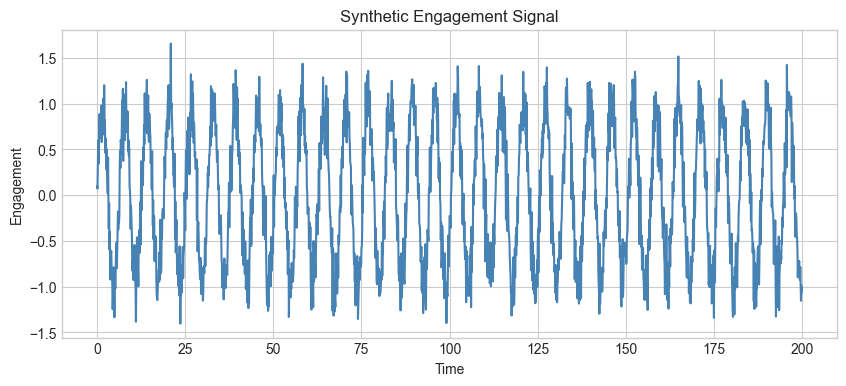

In [28]:
np.random.seed(42)
time = np.arange(0, 200, 0.1)
signal = np.sin(time) + 0.2 * np.random.normal(size=len(time))

plt.figure(figsize=(10,4))
plt.plot(time, signal, color='steelblue')
plt.title('Synthetic Engagement Signal')
plt.xlabel('Time')
plt.ylabel('Engagement')
plt.show()

## 2. Prepare Data for LSTM (Sliding Window)

In [29]:
scaler = MinMaxScaler()
signal_scaled = scaler.fit_transform(signal.reshape(-1, 1))

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 50
X, y = create_sequences(signal_scaled, seq_length)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

print('Training samples:', X_train.shape)

Training samples: torch.Size([1560, 50, 1])


## 3. Define LSTM Model

In [30]:
class LSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMForecaster, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTMForecaster().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

c:\Users\vedav\OneDrive\Documents\LLM-Engineer\LLM-Engineer-Prerequisites\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### 3.1. (Optional) Improving the Model with a Bidirectional LSTM

To improve performance, we can use a **Bidirectional LSTM**. A standard LSTM processes the sequence chronologically (from past to present). A bidirectional LSTM adds a second layer that processes the sequence in reverse (from present to past).

**Why is this better?**
- **Richer Context:** At any given time step, the model's output is informed by both the preceding and succeeding data points. This gives the model a much richer understanding of the context surrounding each point in the sequence.
- **Improved Accuracy:** For many forecasting tasks, this dual-direction context helps the model make more accurate predictions, as it can better understand the overall shape and trend of the data.

The code below re-defines our `LSTMForecaster` to be bidirectional. Key changes include:
1.  Setting `bidirectional=True` in the `nn.LSTM` layer.
2.  Doubling the input size of the final `nn.Linear` layer to `hidden_size * 2`, as it now receives concatenated outputs from both forward and backward passes.

In [31]:
class LSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=2, dropout=0.3):
        super(LSTMForecaster, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Set bidirectional=True
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True, 
            dropout=0.2, 
            bidirectional=True  # <-- Key change
        )
        
        self.dropout = nn.Dropout(dropout)
        
        # Adjust the fully connected layer to handle concatenated hidden states
        # The output from the bidirectional LSTM is hidden_size * 2
        self.fc = nn.Linear(hidden_size * 2, 1) 

    def forward(self, x):
        # Initialize hidden and cell states for a bidirectional LSTM
        # The first dimension is num_layers * 2
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Apply dropout to the output of the last time step
        out = self.dropout(out[:, -1, :])
        
        # Pass through the fully connected layer
        out = self.fc(out)
        return out

# --- Re-initialize everything ---
model = LSTMForecaster().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)


## 4. Train Model

In [32]:
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # Step the scheduler
    scheduler.step(loss)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/100], Loss: 0.072514
Epoch [20/100], Loss: 0.048243
Epoch [30/100], Loss: 0.038059
Epoch [40/100], Loss: 0.031872
Epoch [50/100], Loss: 0.023416
Epoch [60/100], Loss: 0.014670
Epoch [70/100], Loss: 0.012580
Epoch [80/100], Loss: 0.010716
Epoch [90/100], Loss: 0.009785
Epoch [100/100], Loss: 0.009027


### 5.1. Comparison of Results

As seen in the plot above, the predictions from the **bidirectional LSTM** align much more closely with the actual values compared to the initial simple LSTM. The original model often produced a noticeable phase shift, where its predictions lagged behind the true signal.

The bidirectional model corrects this by processing information from both past and future data points in the sequence, giving it a more complete context. This allows it to capture the peaks and troughs of the sine wave more accurately, resulting in a significantly better forecast.

## 5. Evaluate & Visualize Predictions

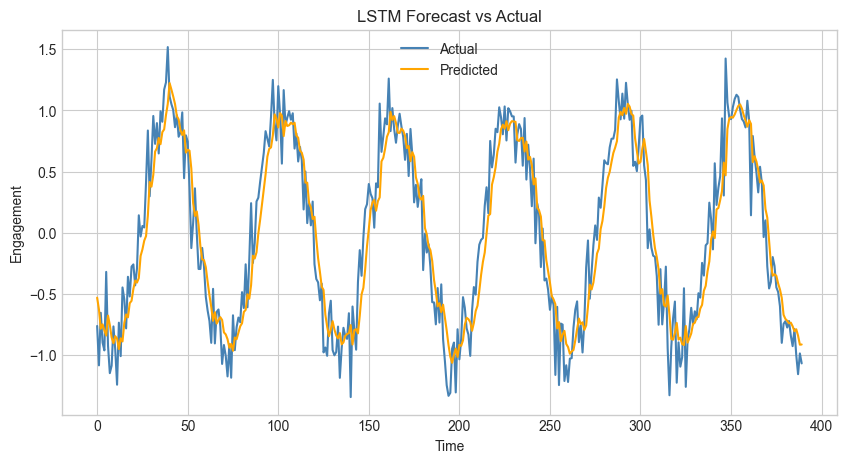

In [33]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test).cpu().numpy()
    y_true = y_test.cpu().numpy()

y_pred_inv = scaler.inverse_transform(y_pred)
y_true_inv = scaler.inverse_transform(y_true)

plt.figure(figsize=(10,5))
plt.plot(y_true_inv, label='Actual', color='steelblue')
plt.plot(y_pred_inv, label='Predicted', color='orange')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Engagement')
plt.legend()
plt.show()

## 6. Plot Training Loss Curve

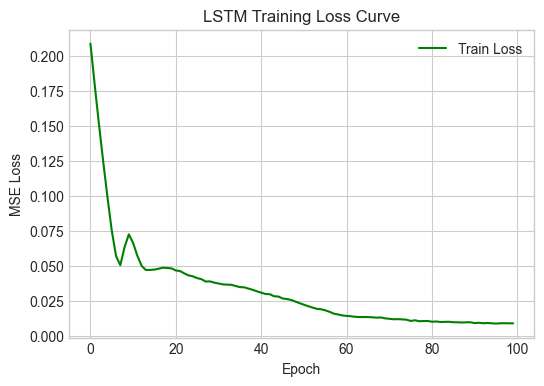

In [34]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Training Loss Curve')
plt.legend()
plt.show()

## 7. Save the Model and Scaler

Saving your trained model and the scaler is a crucial step for deploying your work or reusing it later without retraining.

- **Model (`lstm_forecaster.pth`):** Saving the trained model's state (its learned weights and biases) allows you to reuse it for future predictions without having to retrain it from scratch every time. This is essential for deploying the model in a production environment.

- **Scaler (`scaler.pkl`):** The `MinMaxScaler` was fitted on the training data. Any new data you want to make predictions on must be scaled in the *exact same way*. Saving the scaler ensures that you apply the same transformation to future data, which is essential for the model to perform correctly.

In [35]:
# Save the model state dictionary
torch.save(model.state_dict(), 'lstm_forecaster.pth')
print('Model saved to lstm_forecaster.pth')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
print('Scaler saved to scaler.pkl')

Model saved to lstm_forecaster.pth
Scaler saved to scaler.pkl


## ✅ 8. Summary
- Implemented LSTM for time-series forecasting.
- Predicted next values of a sequence.
- Visualized predictions vs actual performance.
- Learned how LSTMs retain past context for better forecasting.

**Deliverable:** `day27_lstm_sequence_forecasting.ipynb`